# **Arabic Dialect Identification**

Many countries speak Arabic; however, each country has its own dialect, the aim of this notebook is to build a model that predicts the dialect given the text. 

**Steps:**


1.   Read dataset from API [https://recruitment.aimtechnologies.co/ai-tasks]
2.   Clean arabic dataset
3.   Normalize arabic dataset
4.   Vectorize arabic dataset
5.   Modeling and evaluation






# **Import Libraries**

Install tashaphyne to normalize text


In [1]:
!pip install tashaphyne

In [2]:
#Read Data
import pandas as pd
import requests

#Clean Data
import re
from nltk import word_tokenize

#Normalization
from tashaphyne.normalize import normalize_searchtext

#Feature Extraction
from sklearn.feature_extraction.text import  CountVectorizer,TfidfVectorizer

#Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

#Evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

#Split Data into train and test
from sklearn.model_selection import train_test_split


# **Read dataset from API**

In [3]:
URL = 'https://recruitment.aimtechnologies.co/ai-tasks'
PATH = 'dialect_dataset.csv'

In [4]:
ids = pd.read_csv(PATH)
ids.head(3)

,id,dialect
0,1175358310087892992,IQ
1,1175416117793349632,IQ
2,1175450108898565888,IQ


In [5]:
len(ids)

458197

In [6]:
ids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458197 entries, 0 to 458196
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       458197 non-null  int64 
 1   dialect  458197 non-null  object
dtypes: int64(1), object(1)
memory usage: 7.0+ MB


In [7]:
ids['dialect'].unique()

array(['IQ', 'LY', 'QA', 'PL', 'SY', 'TN', 'JO', 'MA', 'SA', 'YE', 'DZ',
       'EG', 'LB', 'KW', 'OM', 'SD', 'AE', 'BH'], dtype=object)

In [8]:
len(ids['dialect'].unique())

18

In [9]:
ids['dialect'].value_counts()

EG    57636
PL    43742
KW    42109
LY    36499
QA    31069
JO    27921
LB    27617
SA    26832
AE    26296
BH    26292
OM    19116
SY    16242
DZ    16183
IQ    15497
SD    14434
MA    11539
YE     9927
TN     9246
Name: dialect, dtype: int64

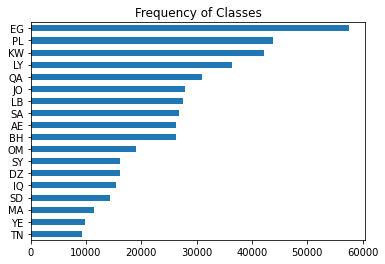

In [10]:
import matplotlib.pyplot as plt

ids["dialect"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [11]:
def readDataFromAPI(data):
  headers={'id':'text'}
  result = requests.post(URL, headers=headers, json=data)
  return result.json()

def convertJson2Dataframe(dataJson):
  dic={'id':[],'text':[] }
  for k in dataJson:
    dic['id'].append(k)
    dic['text'].append(dataJson[k])
  return pd.DataFrame(dic)

In [12]:
ids['id']= ids['id'].astype(str)

In [13]:
i = 0 
dataFromAPI = pd.DataFrame([] ,  columns = ['id', 'text'])
while True:
  df_data = convertJson2Dataframe(readDataFromAPI(list(ids['id'][i:i+1000])))
  dataFromAPI = pd.concat([dataFromAPI, df_data])
  i+=1000
  if len(ids['id']) - i < 1000:
    df_data = convertJson2Dataframe(readDataFromAPI(list(ids['id'][i:])))
    dataFromAPI = pd.concat([dataFromAPI,df_data ])
    break
dataFromAPI.head()

,id,text
0,1175358310087892992,@Nw8ieJUwaCAAreT لكن بالنهاية .. ينتفض .. يغير .
1,1175416117793349632,@7zNqXP0yrODdRjK يعني هذا محسوب على البشر .. ح...
2,1175450108898565888,@KanaanRema مبين من كلامه خليجي
3,1175471073770573824,@HAIDER76128900 يسلملي مرورك وروحك الحلوه💐
4,1175496913145217024,@hmo2406 وين هل الغيبه اخ محمد 🌸🌺


In [14]:
data =pd.merge(ids, dataFromAPI, on="id")
data.head()

,id,dialect,text
0,1175358310087892992,IQ,@Nw8ieJUwaCAAreT لكن بالنهاية .. ينتفض .. يغير .
1,1175416117793349632,IQ,@7zNqXP0yrODdRjK يعني هذا محسوب على البشر .. ح...
2,1175450108898565888,IQ,@KanaanRema مبين من كلامه خليجي
3,1175471073770573824,IQ,@HAIDER76128900 يسلملي مرورك وروحك الحلوه💐
4,1175496913145217024,IQ,@hmo2406 وين هل الغيبه اخ محمد 🌸🌺


In [15]:
data.to_csv('Data.csv', columns=['id','dialect','text'], index=False)

# **Clean dataset**

In [16]:
dataDF = pd.read_csv('Data.csv',lineterminator='\n')
dataDF.head(2)

,id,dialect,text
0,1175358310087892992,IQ,@Nw8ieJUwaCAAreT لكن بالنهاية .. ينتفض .. يغير .
1,1175416117793349632,IQ,@7zNqXP0yrODdRjK يعني هذا محسوب على البشر .. ح...


In [17]:
#check if there is any non-arabic
dataDF[dataDF['text'].apply(lambda x : bool(re.match("[a-zA-Z0-9]", x))) == True].head()

,id,dialect,text
1270,575285642424381440,IQ,http://t.co/VVVVl1n26g\nهسه هذا منو جابه ؟ عرب...
1306,761166631720652800,IQ,Mushtaq Talib \nسؤال بغلاة خميس الخنجر عندك \n...
1928,942500530735255552,IQ,3 محاضرات من اصل 7 \nتره كلش كافي واصلا تعبت روحي
2043,790699683010207744,IQ,https://t.co/sdDEtigqiY حزينة الدار والدله علي...
2620,989608659419353216,IQ,I found him \nهسه شلون اضبطه كلش ثكيل خررب احد...


In [18]:
def cleanData(data):
  data['text'] = data['text'].apply(lambda x : re.sub("@\s[W+]\s",'', x))    #remove @username
  data['text'] = data['text'].apply(lambda x : re.sub("http\S+\s*",'', x))   #remove links http:------
  data['text'] = data['text'].apply(lambda x : re.sub("[a-zA-Z0-9]",'', x))  #remove all non-arabic
  data['text'] = data['text'].apply(lambda x : re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""),'', x)) 
  data['text'] = data['text'].apply(lambda x : re.sub("[(\U0001F600-\U0001F92F|\U0001F300-\U0001F5FF|\U0001F680-\U0001F6FF|\U0001F190-\U0001F1FF|\U00002702-\U000027B0|\U0001F926-\U0001FA9F|\u200d|\u2640-\u2642|\u2600-\u2B55|\u23cf|\u23e9|\u231a|\ufe0f)]+",
                                                      '', x))  #remove emotions
  data['text'] = data['text'].apply(lambda x : re.sub(r'(.)\1+', r'\1', x))  #remove repeating letters
  data['text'] = data['text'].apply(lambda x : x.rstrip()) 

  return data




In [19]:
stop_words =['من','في','على', 'و','فى','يا', 'عن','مع','ان','هو','علي','ما','اللي','كل',
 'بعد','ده','اليوم', 'أن','يوم','انا','إلى','كان','ايه','اللى','الى','دي','بين','انت','أنا','حتى','لما','فيه','هذا','واحد','احنا','اي','كده',
 'إن','او','أو','عليه','ف','دى','مين','الي','كانت','أمام','زي','يكون','خلال','ع','كنت','هي','فيها','عند','التي','الذي','قال','هذه','قد','انه','ريتويت','بعض','أول','ايه',
 'الان','أي','منذ','عليها','له','ال','تم','ب','دة','عليك'
 ,'اى','كلها','اللتى','هى','دا','انك','وهو', 'ومن','منك','نحن','زى','أنت','انهم','معانا','حتي','وانا','عنه','إلي','ونحن','وانت','منكم','وان','معاهم','معايا','وأنا','عنها','إنه',
 'اني','معك','اننا','فيهم','د','انتا','عنك','وهى','معا','آن','انتي','وأنت','وإن','ومع','وعن','معاكم','معاكو','معاها','وعليه','وانتم','وانتي','¿','|']

In [20]:
def removing_stopwords(text):
    """
        Here we remove all Arabic stop words 
    """
    original_words = []
    words = word_tokenize(text)
    for word in words:
        if word not in stop_words:
            original_words.append(word)
    filtered_sentence = " ".join(original_words)
    return filtered_sentence

In [21]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [22]:
dataDF['text'] = dataDF['text'].apply(lambda x :  removing_stopwords(x) )

In [23]:
cleanDF = cleanData(dataDF)
cleanDF.head()

,id,dialect,text
0,1175358310087892992,IQ,لكن بالنهاية ينتفض يغير
1,1175416117793349632,IQ,يعني محسوب البشر حيونه وحشيه وتطلبون الغرب يح...
2,1175450108898565888,IQ,مبين كلامه خليجي
3,1175471073770573824,IQ,يسلملي مرورك وروحك الحلوه
4,1175496913145217024,IQ,وين هل الغيبه اخ محمد


In [24]:
cleanDF.to_csv('clean_data.csv', columns=['id','dialect','text'], index=False)

# **Normalize dataset**


In [25]:
df = pd.read_csv('clean_data.csv',lineterminator='\n')
df.head(2)

,id,dialect,text
0,1175358310087892992,IQ,لكن بالنهاية ينتفض يغير
1,1175416117793349632,IQ,يعني محسوب البشر حيونه وحشيه وتطلبون الغرب يح...


**normalize_searchtext:** Normalize input text and return a result text. Normalize a text by :

1.  strip tashkeel
2.  strip tatweel
3.  normalize Hamza
4.  normalize Lam Alef
5.  normalize Teh Marbuta and Alef Maksura


In [26]:
df['text'] = df['text'].apply(lambda x : normalize_searchtext(str(x)))
df.head()

,id,dialect,text
0,1175358310087892992,IQ,لكن بالنهايه ينتفض يغير
1,1175416117793349632,IQ,يعني محسوب البشر حيونه وحشيه وتطلبون الغرب يح...
2,1175450108898565888,IQ,مبين كلامه خليجي
3,1175471073770573824,IQ,يسلملي مرورك وروحك الحلوه
4,1175496913145217024,IQ,وين هل الغيبه اخ محمد


In [27]:
df.to_csv('normalize_data.csv', columns=['id','dialect','text'], index=False)

# **Vectorize dataset**

In [28]:
def count_vectorizer(Xtrain,Xtest,ngram=1):
  cvec = CountVectorizer(lowercase=False, ngram_range=(1,ngram))
  X_train_cv = cvec.fit_transform(Xtrain)
  X_test_cv = cvec.transform(Xtest)
  return X_train_cv,X_test_cv

In [29]:
def Tfidf_vectorizer(Xtrain,Xtest,ngram=1):
  cvec = TfidfVectorizer(lowercase=False, ngram_range=(1,ngram))
  X_train_tfidf= cvec.fit_transform(Xtrain)
  X_test_tfidf = cvec.transform(Xtest)
  return X_train_tfidf,X_test_tfidf

# **Build Models** 

In [30]:
normalizeDF = pd.read_csv('normalize_data.csv',lineterminator='\n')
normalizeDF.head(2)

,id,dialect,text
0,1175358310087892992,IQ,لكن بالنهايه ينتفض يغير
1,1175416117793349632,IQ,يعني محسوب البشر حيونه وحشيه وتطلبون الغرب يح...


In [31]:
normalizeDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458197 entries, 0 to 458196
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       458197 non-null  int64 
 1   dialect  458197 non-null  object
 2   text     458177 non-null  object
dtypes: int64(1), object(2)
memory usage: 10.5+ MB


In [32]:
normalizeDF = normalizeDF.dropna()

In [33]:
normalizeDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 458177 entries, 0 to 458196
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       458177 non-null  int64 
 1   dialect  458177 non-null  object
 2   text     458177 non-null  object
dtypes: int64(1), object(2)
memory usage: 14.0+ MB


In [34]:
#from sklearn.utils import shuffle
#normalizeDF = shuffle(normalizeDF)

In [35]:
encode={'IQ':0, 'LY':1, 'QA':2, 'PL':3, 'SY':4, 'TN':5, 'JO':6, 'MA':7, 'SA':8, 'YE':9, 'DZ':10,
       'EG':11, 'LB':12, 'KW':13, 'OM':14, 'SD':15, 'AE':16, 'BH':17}

normalizeDF['dialect'] = normalizeDF['dialect'].map(encode)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [36]:
X = normalizeDF['text']
y = normalizeDF['dialect']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42,shuffle=True)
print(X_train.shape)
print(X_test.shape)

(366541,)
(91636,)


In [38]:
X_train_cv,X_test_cv = count_vectorizer(X_train,X_test)

In [39]:
X_train_tfidf,X_test_tfidf = Tfidf_vectorizer(X_train,X_test)

MultinomialNB Classifier with CountVectorizer

In [40]:
NBg_cv= MultinomialNB()
NBg_cv.fit(X = X_train_cv, y = y_train)
print('\033[1mBasic Tokenisation (CountVectoziser) with Naive Bayes\033[0m')
print('train', NBg_cv.score(X_train_cv, y_train))
print('test', NBg_cv.score(X_test_cv, y_test))
print('f1_score for training', f1_score(y_train,NBg_cv.predict(X_train_cv),average='macro'))
print(classification_report(y_test, NBg_cv.predict(X_test_cv)))

Basic Tokenisation (CountVectoziser) with Naive Bayes
train 0.6495207903072234
test 0.4903313108385351
f1_score for training 0.6046970897549413
              precision    recall  f1-score   support

           0       0.90      0.30      0.45      3099
           1       0.66      0.68      0.67      7300
           2       0.42      0.53      0.47      6214
           3       0.39      0.66      0.49      8748
           4       0.77      0.09      0.16      3248
           5       0.94      0.18      0.30      1849
           6       0.54      0.17      0.25      5584
           7       0.93      0.47      0.62      2308
           8       0.47      0.32      0.38      5366
           9       0.88      0.02      0.05      1985
          10       0.79      0.37      0.51      3237
          11       0.53      0.93      0.67     11526
          12       0.66      0.62      0.64      5523
          13       0.33      0.75      0.46      8422
          14       0.79      0.11      0.19  

MultinomialNB Classifier with TFidfVectorizer

In [41]:
NBg_tfidf = MultinomialNB()
NBg_tfidf.fit(X = X_train_tfidf, y = y_train)
print('\033[1mBasic Tokenisation (TFidfVectorizer) with Naive Bayes\033[0m')
print('train', NBg_tfidf.score(X_train_tfidf, y_train))
print('test', NBg_tfidf.score(X_test_tfidf, y_test))
print('f1_score for training', f1_score(y_train,NBg_tfidf.predict(X_train_tfidf),average='macro'))
print(classification_report(y_test, NBg_tfidf.predict(X_test_tfidf)))

Basic Tokenisation (TFidfVectorizer) with Naive Bayes
train 0.5042355425450359
test 0.4041533894975774
f1_score for training 0.38863969044572666
              precision    recall  f1-score   support

           0       0.97      0.10      0.18      3099
           1       0.66      0.59      0.62      7300
           2       0.52      0.39      0.44      6214
           3       0.33      0.65      0.44      8748
           4       0.94      0.03      0.06      3248
           5       0.98      0.02      0.05      1849
           6       0.74      0.06      0.12      5584
           7       0.99      0.23      0.37      2308
           8       0.62      0.15      0.24      5366
           9       1.00      0.00      0.01      1985
          10       0.88      0.18      0.30      3237
          11       0.36      0.97      0.52     11526
          12       0.80      0.44      0.57      5523
          13       0.29      0.80      0.42      8422
          14       0.97      0.04      0.07 

LogisticRegression Classifier with CountVectorizer

In [42]:
LRg_cv = LogisticRegression(max_iter=1000,random_state=0)
LRg_cv.fit(X = X_train_cv, y = y_train)

print('\033[1mBasic Tokenisation (CountVectorizer), with LogisticRegression\033[0m')
print('train', LRg_cv.score(X_train_cv, y_train))
print('test', LRg_cv.score(X_test_cv, y_test))
print('f1_score for training', f1_score(y_train,LRg_cv.predict(X_train_cv),average='macro'))

print(classification_report(y_test, LRg_cv.predict(X_test_cv)))

Basic Tokenisation (CountVectorizer), with LogisticRegression
train 0.857273811115264
test 0.5202431358854599
f1_score for training 0.8550918471233662
              precision    recall  f1-score   support

           0       0.64      0.50      0.57      3099
           1       0.63      0.68      0.65      7300
           2       0.48      0.47      0.47      6214
           3       0.45      0.54      0.49      8748
           4       0.48      0.32      0.38      3248
           5       0.68      0.41      0.51      1849
           6       0.41      0.35      0.38      5584
           7       0.78      0.56      0.66      2308
           8       0.40      0.41      0.41      5366
           9       0.38      0.18      0.24      1985
          10       0.63      0.50      0.56      3237
          11       0.63      0.82      0.72     11526
          12       0.62      0.63      0.62      5523
          13       0.46      0.56      0.51      8422
          14       0.41      0.34     

LogisticRegression Classifier with TfidfVectorizer

In [44]:
LRg_tfidf = LogisticRegression(max_iter=1000,random_state=0)
LRg_tfidf.fit(X = X_train_tfidf, y = y_train)
print('\033[1mBasic Tokenisation (TFidfVectorizer) with LogisticRegression\033[0m')
print('train', LRg_tfidf.score(X_train_tfidf, y_train))
print('test', LRg_tfidf.score(X_test_tfidf, y_test))
print('f1_score for training', f1_score(y_train,LRg_tfidf.predict(X_train_tfidf),average='macro'))
print(classification_report(y_test, LRg_tfidf.predict(X_test_tfidf)))

Basic Tokenisation (TFidfVectorizer) with LogisticRegression
train 0.697493595532287
test 0.518202453184338
f1_score for training 0.6679734438860293
              precision    recall  f1-score   support

           0       0.70      0.47      0.56      3099
           1       0.60      0.69      0.64      7300
           2       0.46      0.48      0.47      6214
           3       0.45      0.57      0.50      8748
           4       0.56      0.25      0.35      3248
           5       0.78      0.35      0.48      1849
           6       0.44      0.30      0.36      5584
           7       0.81      0.54      0.65      2308
           8       0.39      0.41      0.40      5366
           9       0.63      0.12      0.20      1985
          10       0.66      0.47      0.55      3237
          11       0.59      0.86      0.70     11526
          12       0.63      0.63      0.63      5523
          13       0.42      0.63      0.50      8422
          14       0.47      0.29      0

Save LogisticRegression Model with CountVectorizer

In [45]:
import joblib

filename = 'LogisticRegrassion_CV.sav'
joblib.dump(LRg_cv, filename)

['LogisticRegrassion_CV.sav']

In [46]:
filename = 'LogisticRegrassion_Tfidf.sav'
joblib.dump(LRg_tfidf, filename)

['LogisticRegrassion_Tfidf.sav']

In [47]:
cvec = CountVectorizer(lowercase=False, ngram_range=(1,1)).fit(X_train)
filename = 'CountVectorizer.sav'
joblib.dump(cvec, filename)

['CountVectorizer.sav']

In [48]:
tfidf = TfidfVectorizer(lowercase=False, ngram_range=(1,1)).fit(X_train)
filename = 'TfidfVectorizer.sav'
joblib.dump(tfidf, filename)

['TfidfVectorizer.sav']